# EWB paper figure 1: showing all the cases

We provide the exact code used to generate each figure in order to be completely reproducible and to encourage others to use EWB with their own models quickly. 
This is Figure 1, the initial figure that shows all of the cases, both globally and then zoomed in

In [13]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
import urllib.request
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from extremeweatherbench import evaluate, utils, cases, defaults
sns.set_theme(style='whitegrid')
from shapely.geometry import Polygon
import shapely
from pathlib import Path

# make the basepath - change this to your local path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'

In [14]:
# load in all of the events in the yaml file
case_dict = utils.load_events_yaml()

# turn the dictionary into a list of case objects
ewb_cases = cases.load_individual_cases(case_dict)

# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(case_dict, defaults.BRIGHTBAND_EVALUATION_OBJECTS)

This function is deprecated and will be removed in a future release. Please use cases.load_ewb_events_yaml_into_case_collection instead.
This function is deprecated and will be removed in a future release. Please use cases.read_incoming_yaml instead.


In [91]:
# useful for debugging
print(ewb_cases)


IndividualCaseCollection(cases=[IndividualCase(case_id_number=1, title='2021 Pacific Northwest', start_date=datetime.datetime(2021, 6, 20, 0, 0), end_date=datetime.datetime(2021, 7, 3, 0, 0), location=CenteredRegion(latitude=47.6062, longitude=237.6679, bounding_box_degrees=5), event_type='heat_wave'), IndividualCase(case_id_number=2, title='2022 Upper Midwest', start_date=datetime.datetime(2022, 5, 7, 0, 0), end_date=datetime.datetime(2022, 5, 17, 0, 0), location=CenteredRegion(latitude=41.8781, longitude=272.3702, bounding_box_degrees=5), event_type='heat_wave'), IndividualCase(case_id_number=3, title='2022 California', start_date=datetime.datetime(2022, 6, 7, 0, 0), end_date=datetime.datetime(2022, 6, 15, 0, 0), location=CenteredRegion(latitude=34.0522, longitude=241.7563, bounding_box_degrees=5), event_type='heat_wave'), IndividualCase(case_id_number=4, title='2022 Texas', start_date=datetime.datetime(2022, 6, 30, 0, 0), end_date=datetime.datetime(2022, 7, 18, 0, 0), location=Cente

In [66]:
# helper functions to make the main plotting function cleaner
# helper function to convert a bounding box tuple to a shapely Polygon
def get_polygon_from_bounding_box(bounding_box):
    """Convert a bounding box tuple to a shapely Polygon."""
    if bounding_box is None:
        return None
    left_lon, right_lon, bot_lat, top_lat = bounding_box
    return Polygon(
        [
            (left_lon, bot_lat),
            (right_lon, bot_lat),
            (right_lon, top_lat),
            (left_lon, top_lat),
            (left_lon, bot_lat),
        ]
    )

# helper function to plot a polygon on a cartopy axis
def plot_polygon(polygon, ax, color='yellow', alpha=0.5, my_zorder=1):
    """Plot a shapely Polygon on a Cartopy axis."""
    if polygon is None:
        return
    patch = patches.Polygon(
        polygon.exterior.coords,
        closed=True,
        facecolor=color,
        edgecolor='black',
        alpha=alpha,
        zorder=my_zorder,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(patch)

# helper function to plot a polygon on a cartopy axis
def plot_polygon_outline(polygon, ax, color='yellow', alpha=0.5, my_zorder=1):
    """Plot a shapely Polygon on a Cartopy axis."""
    if polygon is None:
        return
    patch = patches.Polygon(
        polygon.exterior.coords,
        closed=True,
        facecolor='none',
        edgecolor=color,
        alpha=alpha,
        linewidth=2,
        zorder=my_zorder,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(patch)


# main plotting function for plotting all cases
def plot_all_cases(ewb_cases, event_type=None, filename=None, bounding_box=None):
    """A function to plot all cases
    Args:
        ewb_cases (list): A list of cases to plot.
        event_type (str): The type of event to plot. If None, all events will be plotted).
        filename (str): The name of the file to save the plot. If None, the plot will not be saved.
        bounding_box (tuple): A tuple of the form (min_lon, min_lat, max_lon, max_lat) to set the bounding box for the plot. If None, the full world map will be plotted.
    """
    # plot all cases on one giant world map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # plot the full map or a subset if bounding_box is specified
    if (bounding_box is None):
        ax.set_global()
    else:
        ax.set_extent(bounding_box, crs=ccrs.PlateCarree())
    
    # save the bounding box polygon to subset the counts later
    if (bounding_box is not None):
        bounding_box_polygon = get_polygon_from_bounding_box(bounding_box)
        #plot_polygon(bounding_box_polygon, ax, color='yellow', alpha=0.5)
        
    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, facecolor='white')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Define colors for each event type
    # use seaborn color palette for colorblind friendly colors
    sns_palette = sns.color_palette("tab10")

    # event_colors = {
    #     'heat_wave': 'firebrick',
    #     'tropical_cyclone': 'darkorange',
    #     'severe_convection': 'orchid',
    #     'atmospheric_river': 'mediumseagreen',
    #     'freeze': 'royalblue',   
    # }
    event_colors = {
            'freeze': sns_palette[0],  
            'heat_wave': sns_palette[3],
            'tropical_cyclone': sns_palette[1],
            'severe_convection': sns_palette[5],
            'atmospheric_river': sns_palette[7],
        }

    # Initialize counts for each event type
    counts_by_type = dict({'freeze': 0, 'heat_wave': 0, 'severe_convection': 0, 'atmospheric_river': 0, 'tropical_cyclone': 0})
    zorders = {'freeze': 10, 'heat_wave': 9, 'atmospheric_river': 2, 'tropical_cyclone': 1, 'severe_convection': 0}
    alphas = {'freeze': 1, 'heat_wave': 1, 'atmospheric_river': 1, 'tropical_cyclone': 1, 'severe_convection': 1}

    # Plot boxes for each case
    for indiv_case in ewb_cases.cases:
        # Get color based on event type
        indiv_event_type = indiv_case.event_type
        color = event_colors.get(indiv_event_type, 'gray')  # Default to gray if event type not found

        # check if the case is inside the bounding box
        if bounding_box is not None:
            if (not shapely.intersects(indiv_case.location.geopandas.geometry[0], bounding_box_polygon)):
                #print(f"Skipping case {indiv_case.case_id_number} as it is outside the bounding box.")
                continue

        # count the events by type
        counts_by_type[indiv_event_type] += 1

        # Plot the case geopandas info
        if (indiv_event_type == event_type or event_type is None):
            # to handle wrapping around the prime meridian, we can't use geopandas plot (and besides it is slow)
            # instead we have multi-polygon patches if it wraps around and we need to plot each polygon separately
            if isinstance(indiv_case.location.geopandas.geometry.iloc[0], shapely.geometry.MultiPolygon):
                for poly in indiv_case.location.geopandas.geometry.iloc[0].geoms:
                    plot_polygon_outline(poly, ax, color=color, alpha=1, my_zorder=zorders[indiv_event_type])
            else:
                plot_polygon_outline(indiv_case.location.geopandas.geometry.iloc[0], ax, color=color, 
                             alpha=alphas[indiv_event_type], my_zorder=zorders[indiv_event_type])


        
    # Create a custom legend for event types
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=event_colors['heat_wave'], alpha=0.9, label='Heat Wave (n = %d)' % counts_by_type['heat_wave']),
        Patch(facecolor=event_colors['freeze'], alpha=0.9, label='Freeze (n = %d)' % counts_by_type['freeze']),
        Patch(facecolor=event_colors['severe_convection'], alpha=0.9, label='Convection (n = %d)' % counts_by_type['severe_convection']),
        Patch(facecolor=event_colors['atmospheric_river'], alpha=0.9, label='Atmospheric River (n = %d)' % counts_by_type['atmospheric_river']),
        Patch(facecolor=event_colors['tropical_cyclone'], alpha=0.9, label='Tropical Cyclone (n = %d)' % counts_by_type['tropical_cyclone']),
    ]
    # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    if (event_type is None):
        title = 'ExtremeWeatherBench Cases (n = %d)' % sum(counts_by_type.values())
    else:
        title = f'ExtremeWeatherBench Cases: {event_type.replace("_", " ").title()} (n = %d)' % counts_by_type[event_type]
    
    ax.set_title(title, loc='left', fontsize=20)
    
    # save if there is a filename specified (otherwise the user just wants to see the plot)
    if filename is not None:
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=300)

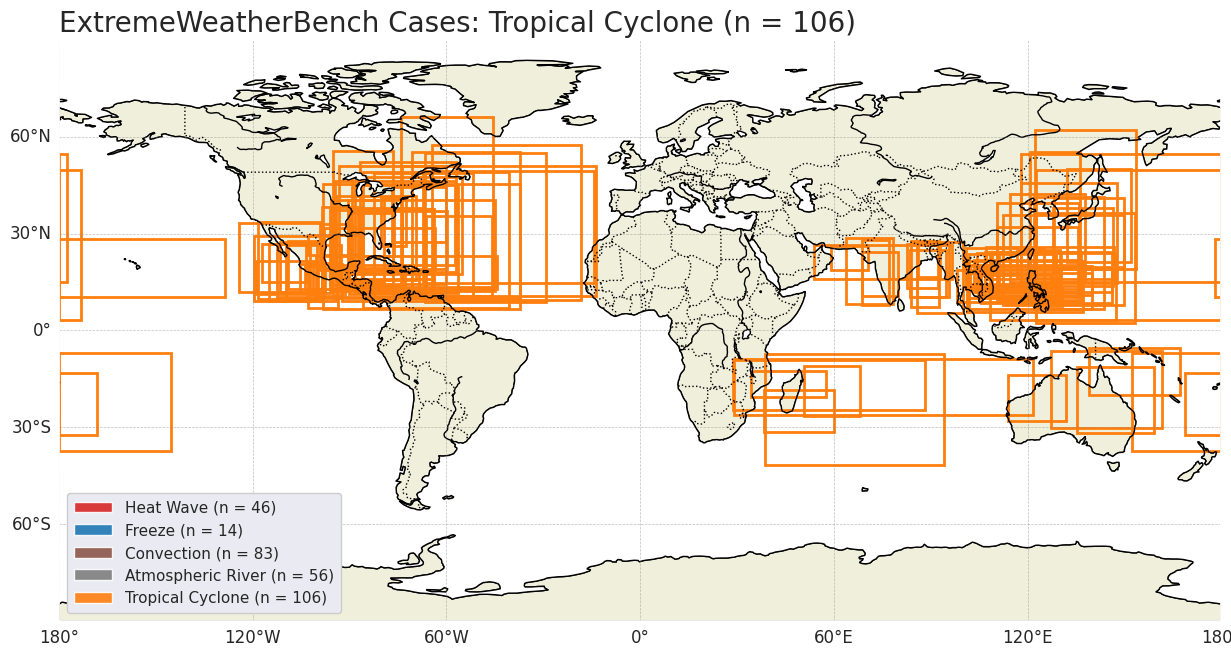

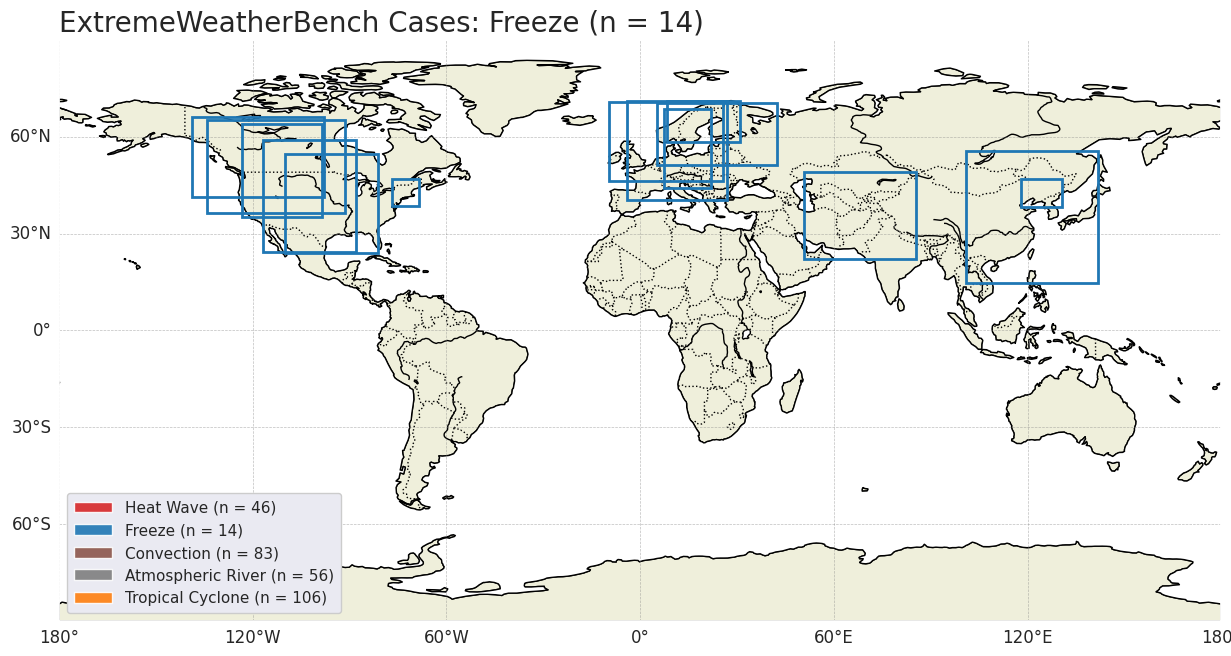

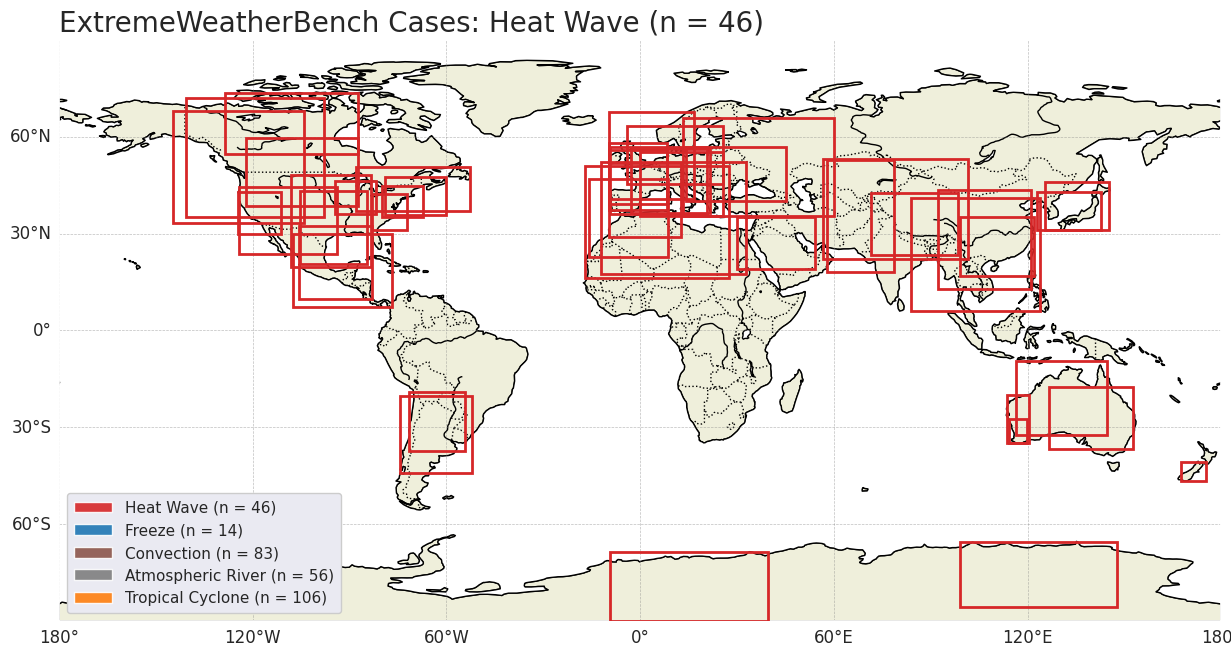

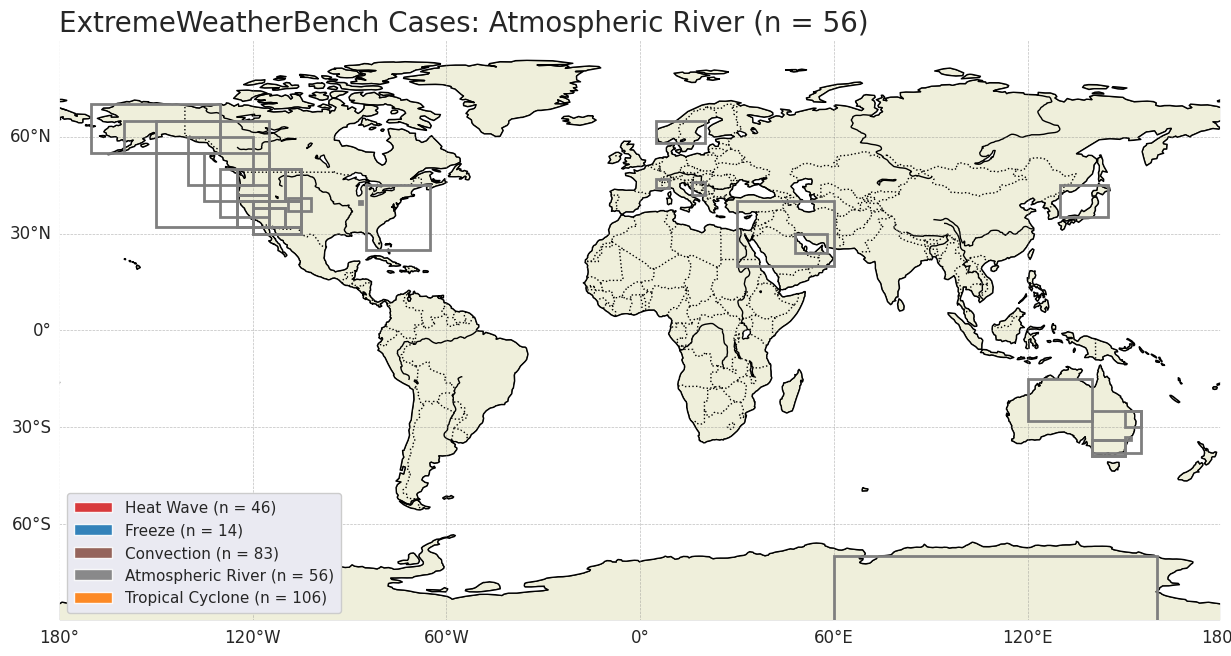

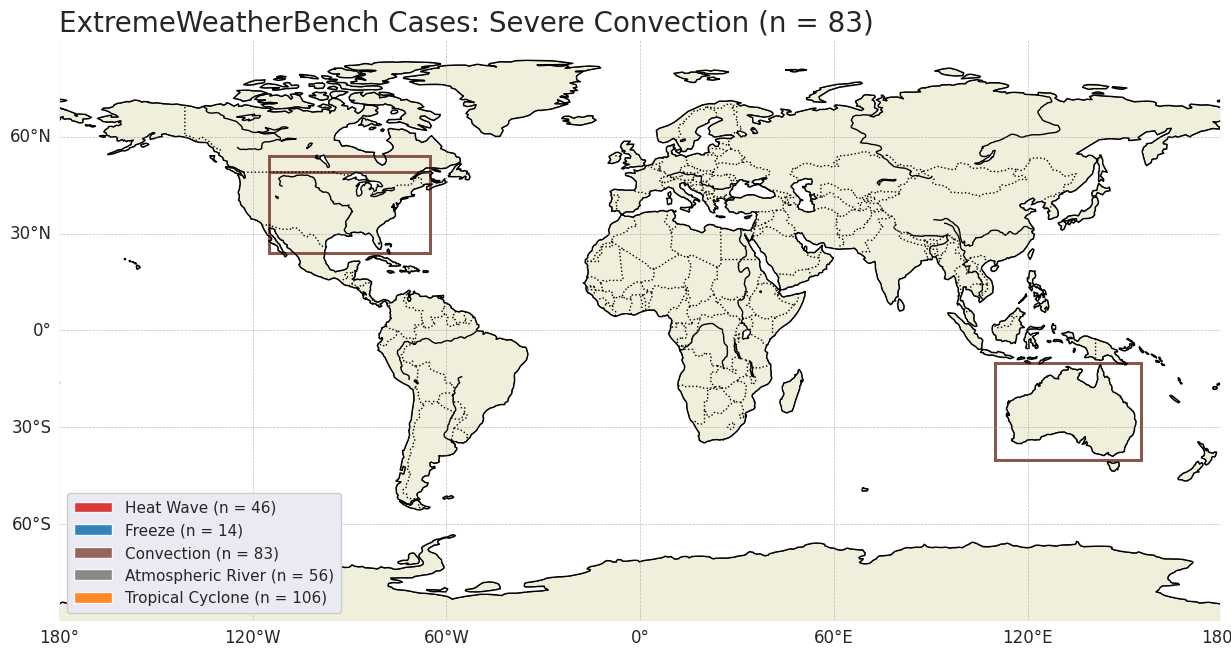

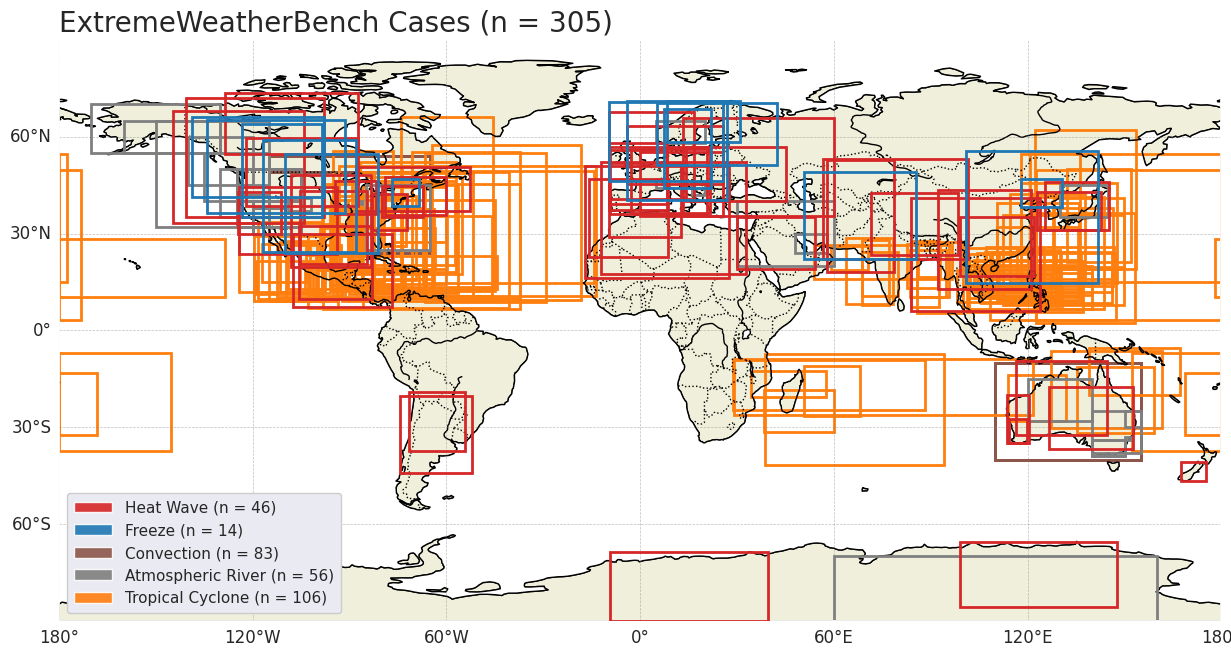

In [67]:
# plot the indivdual cases for each event type
plot_all_cases(ewb_cases, event_type='tropical_cyclone', filename=basepath + 'docs/notebooks/figs/ewb_tcs.png')
plot_all_cases(ewb_cases, event_type='freeze', filename=basepath + 'docs/notebooks/figs/ewb_freeze.png')
plot_all_cases(ewb_cases, event_type='heat_wave', filename=basepath + 'docs/notebooks/figs/ewb_heat.png')
plot_all_cases(ewb_cases, event_type='atmospheric_river', filename=basepath + 'docs/notebooks/figs/ewb_ar.png')
plot_all_cases(ewb_cases, event_type='severe_convection', filename=basepath + 'docs/notebooks/figs/ewb_convective.png')

# plot all cases on one giant world map
plot_all_cases(ewb_cases, event_type=None, filename=basepath + 'docs/notebooks/figs/ewb_all.png')

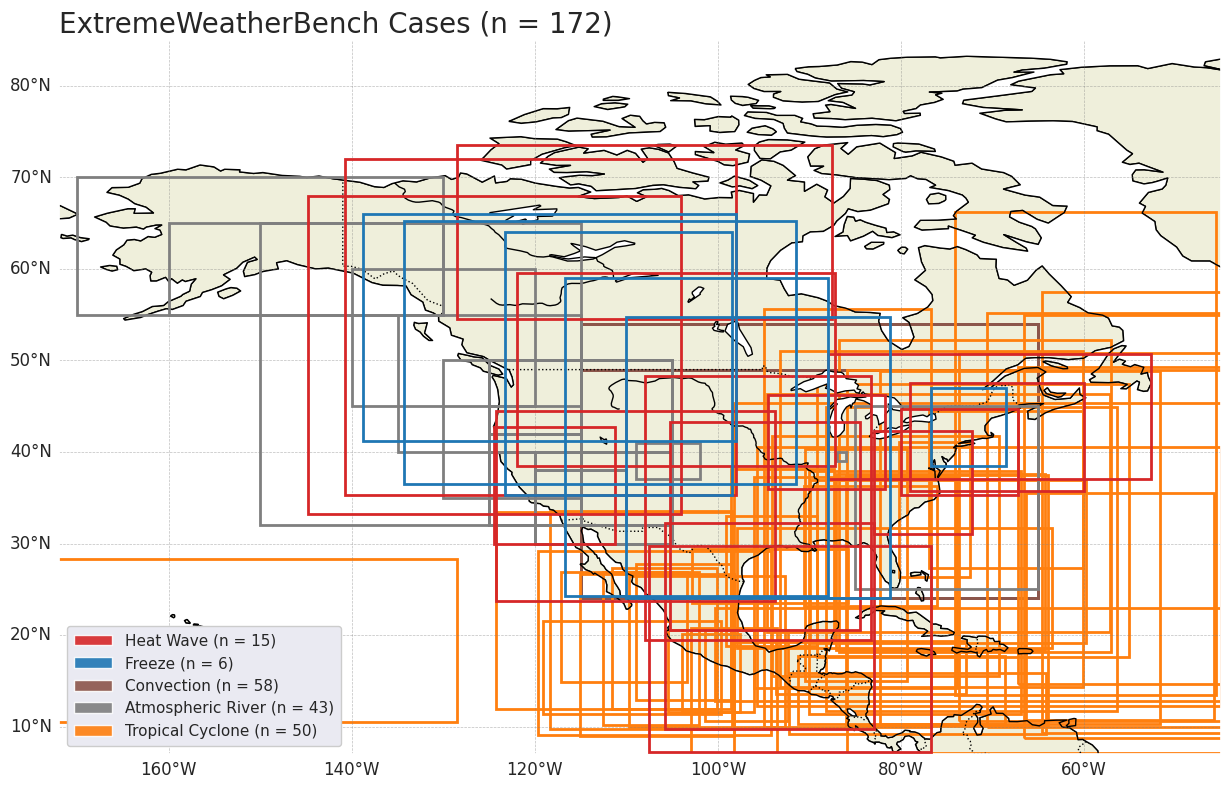

In [68]:
# plot North America
bot_lat = 7
top_lat = 85
left_lon = -172
right_lon = -45

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in North America'

plot_all_cases(ewb_cases, event_type=None, bounding_box=bounding_box, filename=basepath + 'docs/notebooks/figs/extreme_weather_cases_NA.png')

20 -15 20 75


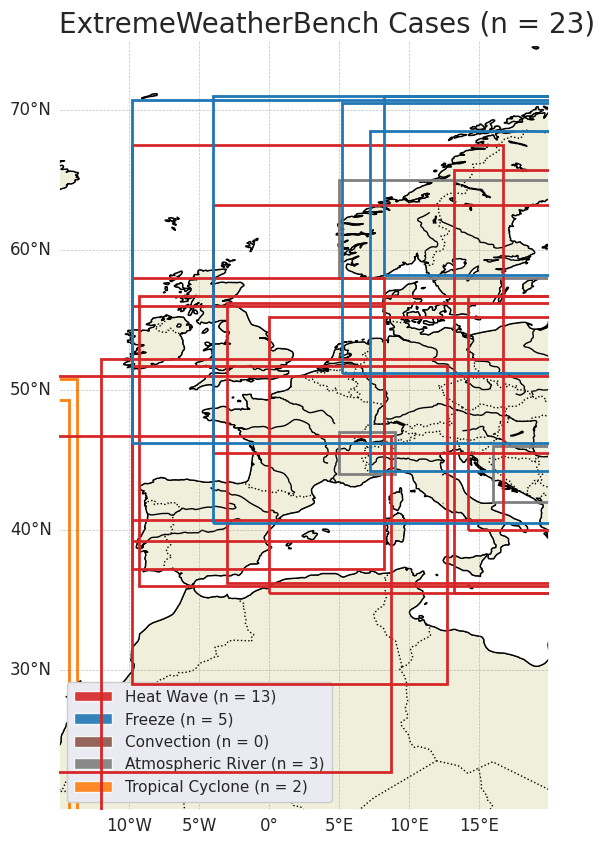

In [69]:
# plot Europe
bot_lat = 20
top_lat = 75
left_lon = -15
right_lon = 20

print(right_lon, left_lon, bot_lat, top_lat)

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in Europe'
plot_all_cases(ewb_cases, event_type=None, bounding_box=bounding_box, filename=basepath + 'docs/notebooks/figs/extreme_weather_cases_Europe.png')


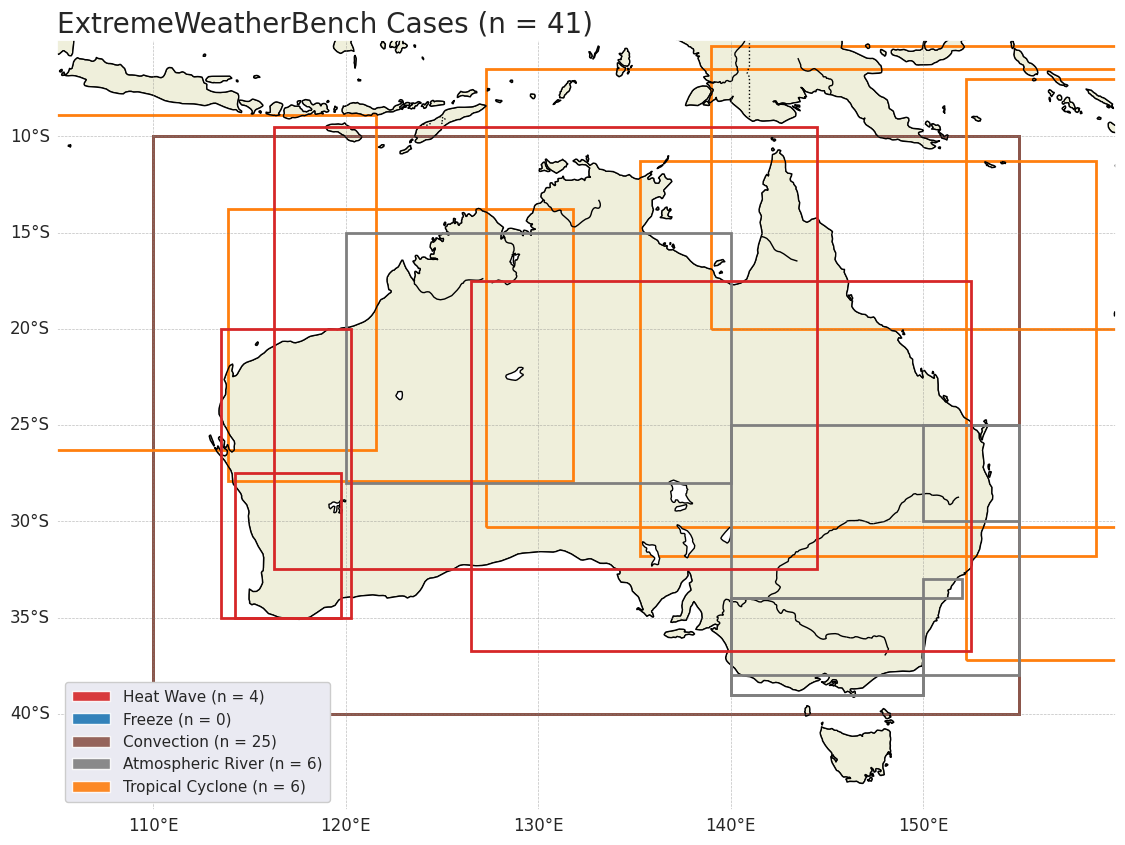

In [72]:
# plot Australia
bot_lat = -45
top_lat = -5
left_lon = 105
right_lon = 160
bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in Australia'

plot_all_cases(ewb_cases, event_type=None, bounding_box=bounding_box, filename=basepath + 'docs/notebooks/figs/extreme_weather_cases_Aus.png')